<a href="https://colab.research.google.com/github/jinayou/intro-numerical-methods/blob/master/ABMcore_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2023.12.04

- Trading preference formula: Dirichlet
- Spreading preference:
    - Successful traders spread their trading strategies
    - There can be overlap (possible for certain trading strategies to be more popular)
- Redistribution:
    - Does NOT redistribute preferences when opinion groups converge
    - Does NOT use determine_distributed_earnings


In [ ]:
pip install mesa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.1/241.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 808.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
pip install powerlaw

In [ ]:
import mesa
import math
import random
import numpy as np
import copy

In [ ]:
class TraderAgent(mesa.Agent):

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model) # Pass the parameters to the parent class.
        self.trading_preference = self.dirichlet_trading_preference()
        self.latest_trading_decision = 0
        self.earnings = 0
        self.historical_earnings = [] # program not set up yet

    ## Trading prefrence formulas ##
    def dirichlet_trading_preference(self):
        return np.random.dirichlet(np.ones((3,), dtype=int), size=1)[0].tolist() # Choose 3 random nums that add up to 1

    # Generate trading decisions based on probabilities
    def trade(self):
        decision = random.choices([1, -1, 0], weights=self.trading_preference, k=1)[0]
        #1=buy, -1=sell, 0=hold
        return decision

    def step(self):
        self.latest_trading_decision = self.trade()
        # self.historical_earnings.append(self.find_latest_earnings())

        # print(f"Agent {self.unique_id}'s trading preferences: {self.trading_preference}")
        # print(f"Agent {self.unique_id}'s trading decision: {self.latest_trading_decision}")

In [ ]:
from re import M
class TradingModel(mesa.Model):

    def __init__(self, N, omega, sensitivity):
        self.num_agents = N
        self.schedule = mesa.time.RandomActivation(self)
        self.data_collector = mesa.datacollection.DataCollector(
            agent_reporters={"Latest Trading Decision": "latest_trading_decision"},
            model_reporters={"Traders' Decisions": "agent_decisions", "Returns": "returns_list"}
        )
        self.returns_list = []
        self.earnings_list = []
        self.latest_return = sum(agent.latest_trading_decision for agent in self.schedule.agents)*sensitivity
        self.current_step=1

       # Add the agent to the scheduler
        for i in range(self.num_agents):
            self.schedule.add(TraderAgent(i, self))

    ## Trading prefrence formulas ##
    def dirichlet_trading_preference(self):
        return np.random.dirichlet(np.ones((3,), dtype=int), size=1)[0].tolist() # Choose 3 random nums that add up to 1


    ## EARNINGS ##
    def compile_earnings_list(self): #create a list of latest (non-distributed) earnings for all agents
        temp_list=[]
        for agent in self.schedule.agents:
          agent.earnings = -self.latest_return*agent.latest_trading_decision #choose which (buyer/seller) is the winner
          temp_list.append(agent.earnings)
        self.earnings_list = temp_list


    ## Preferences ##
    def assign_preferences(self, r):

        #Determine number of opinion groups
        if r != 0:
            num_opinion_groups = int((self.num_agents / (abs(r)))**omega)
        else:
            num_opinion_groups = int(self.num_agents)
        print("New number of opinion groups: ", num_opinion_groups)

        self.spread_preferences(num_opinion_groups)


    def spread_preferences(self, num_opinion_groups):
    #Spread preferences based on whoever was successful in last iteration. If we run out of successful agents, use dirichlet function.

        self.compile_earnings_list()

        # Find indices of successful agents from last iteration
        success_index = []

        for i in range(len(self.earnings_list)):
          if self.earnings_list[i] > 0:
            success_index.append(i)

        trading_preferences = [] #successful trading preferences
        #If we have more successful agents than opinion groups, select opinions randomly from successful agents

        for i in range(num_opinion_groups):
          #If we have more successful agents than opinion groups, select opinions randomly from successful agents
          if i < len(success_index):
            choice = random.choice(success_index) # There can be overlap. Probably twice as more likely to choose the same trading preference
            trading_preferences.append(self.schedule.agents[choice].trading_preference)
          #Otherwise, select preferences randomly for remaining opinion groups
          else:
            trading_preferences.append(self.dirichlet_trading_preference())

        print(trading_preferences)

        num_agents = len(self.schedule.agents)

        # Assign agents evenly to the opinion groups
        for i in range(num_agents):
          self.schedule.agents[i].trading_preference = trading_preferences[i % num_opinion_groups]



    def step(self):

        print("------------------------Beginning of step", self.current_step, "------------------------")
        self.current_step+=1

        # Advance the model by one step
        self.assign_preferences(self.latest_return/sensitivity)
        self.schedule.step()
        self.data_collector.collect(self)

        agent_decisions = [agent.latest_trading_decision for agent in self.schedule.agents]
        # print("Traders' Decisions:", agent_decisions)

        # Calculate and store the cumulative trading decisions from all agents
        self.latest_return = sum(agent.latest_trading_decision for agent in self.schedule.agents)*sensitivity
        print("Return:", self.latest_return)
        self.returns_list.append(self.latest_return)
        # print("Historical Returns:", self.returns_list)


In [ ]:
### RUN MODEL ###

## Parameters

#Sensitivity to price change
sensitivity = 1

#Power of omega term
omega = 1 #Check if omega is incorporated correctly

#Trading velocity
V=1.64
Vf=0.4
Vc=(V - 0.83*Vf)/(1- 0.83)
print(Vc)

#Daily trading probability
p=Vc/(250*2)
q=p
#h=1-p-q

## Run

p_hold=0.4

model = TradingModel(1000, omega, sensitivity) #Number of traders
for i in range(3627): #Number of time steps
    model.step()

print("Returns at Each Step:", model.returns_list)

#Test
# print(model.schedule.agents[1].historical_earnings)


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
New number of opinion groups:  24
[[0.44684139391104744, 0.4664979425740375, 0.08666066351491504], [0.44684139391104744, 0.4664979425740375, 0.08666066351491504], [0.44684139391104744, 0.4664979425740375, 0.08666066351491504], [0.44684139391104744, 0.4664979425740375, 0.08666066351491504], [0.44684139391104744, 0.4664979425740375, 0.08666066351491504], [0.44684139391104744, 0.4664979425740375, 0.08666066351491504], [0.44684139391104744, 0.4664979425740375, 0.08666066351491504], [0.44684139391104744, 0.4664979425740375, 0.08666066351491504], [0.44684139391104744, 0.4664979425740375, 0.08666066351491504], [0.44684139391104744, 0.4664979425740375, 0.08666066351491504], [0.44684139391104744, 0.4664979425740375, 0.08666066351491504], [0.44684139391104744, 0.4664979425740375, 0.08666066351491504], [0.44684139391104744, 0.4664979425740375, 0.08666066351491504], [0.44684139391104744, 0.4664979425740375, 0.08666066351

In [ ]:
output_returns = model.returns_list

In [ ]:
### SAVE THE RESULT IN CSV ###

# This is causing error

'''from google.colab import drive
import csv

# Mount Google Drive
drive.mount('/content/drive')

# Define the file path
file_path = "/content/drive/MyDrive/ABMcore/Output/Output_returns.csv"

# Writing to CSV file
with open(file_path, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(output_returns)'''

'from google.colab import drive\nimport csv\n\n# Mount Google Drive\ndrive.mount(\'/content/drive\')\n\n# Define the file path\nfile_path = "/content/drive/MyDrive/ABMcore/Output/Output_returns.csv"\n\n# Writing to CSV file\nwith open(file_path, \'w\', newline=\'\') as csvfile:\n    csv_writer = csv.writer(csvfile)\n    csv_writer.writerow(output_returns)'



ANALYSIS

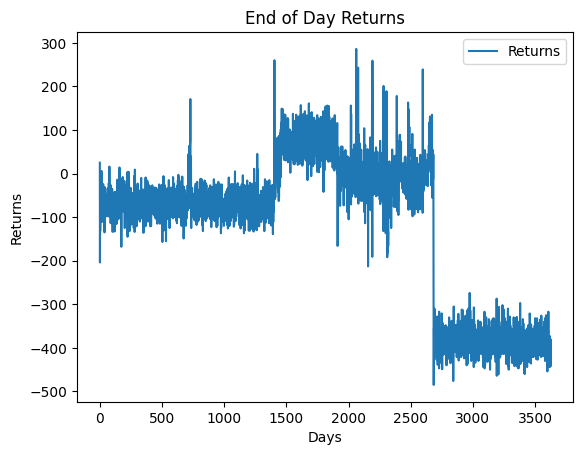

<ipython-input-9-21cbfee64406>:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(output_returns, hist=True, kde=False,


[25, 204, 96, 132, 74, 62, 83, 26, 57, 91, 73, 76, 57, 6, 70, 84, 103, 58, 111, 55, 65, 51, 78, 64, 44, 48, 60, 24, 60, 44, 49, 90, 62, 68, 55, 79, 37, 77, 135, 56, 31, 51, 73, 77, 62, 82, 83, 93, 83, 98, 54, 76, 75, 95, 73, 65, 58, 72, 79, 57, 58, 46, 98, 34, 64, 48, 51, 58, 70, 63, 34, 98, 22, 44, 64, 69, 88, 16, 74, 99, 33, 62, 81, 78, 63, 59, 26, 114, 82, 102, 85, 68, 56, 63, 39, 78, 110, 61, 100, 35, 62, 104, 101, 134, 85, 99, 100, 99, 45, 89, 83, 63, 99, 62, 70, 88, 93, 43, 55, 133, 64, 89, 42, 76, 47, 60, 99, 82, 81, 116, 96, 85, 84, 100, 44, 73, 115, 93, 94, 77, 65, 14, 79, 79, 40, 23, 63, 105, 31, 81, 68, 73, 62, 98, 81, 57, 2, 49, 14, 31, 70, 65, 98, 37, 86, 103, 20, 89, 66, 22, 56, 61, 91, 168, 93, 32, 53, 51, 42, 37, 17, 11, 21, 57, 64, 8, 16, 29, 42, 84, 87, 66, 64, 86, 58, 84, 86, 17, 26, 79, 125, 123, 33, 31, 32, 27, 87, 78, 104, 43, 101, 52, 63, 108, 102, 59, 77, 40, 62, 70, 44, 94, 3, 145, 95, 46, 83, 59, 65, 4, 109, 20, 3, 67, 77, 73, 41, 31, 131, 83, 76, 115, 131, 12

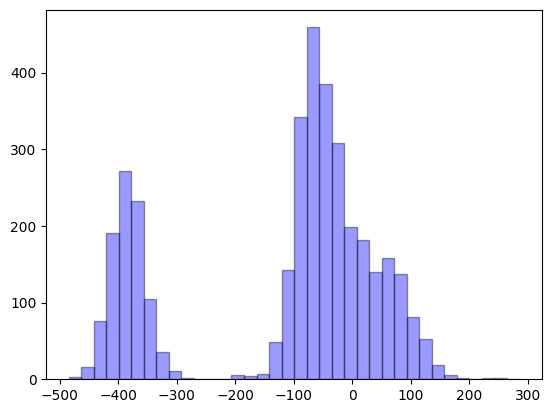

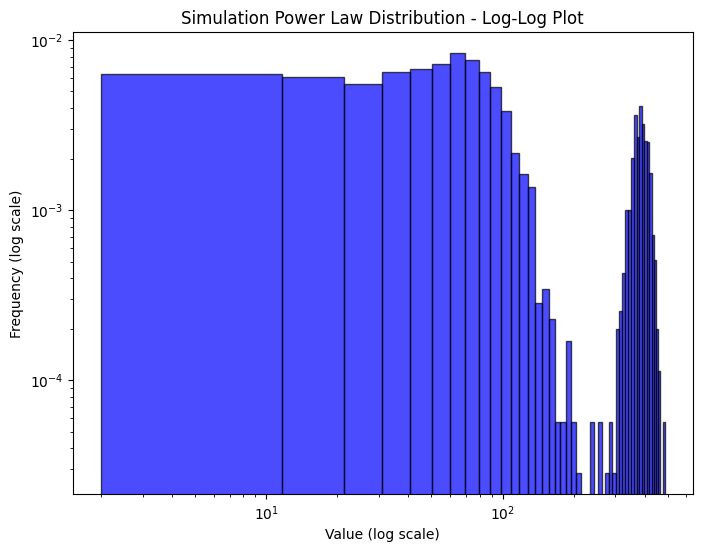

[INFO] computing Hill Estimators...
2

Sample size n: 3627
Total number of exceeded k: 3626


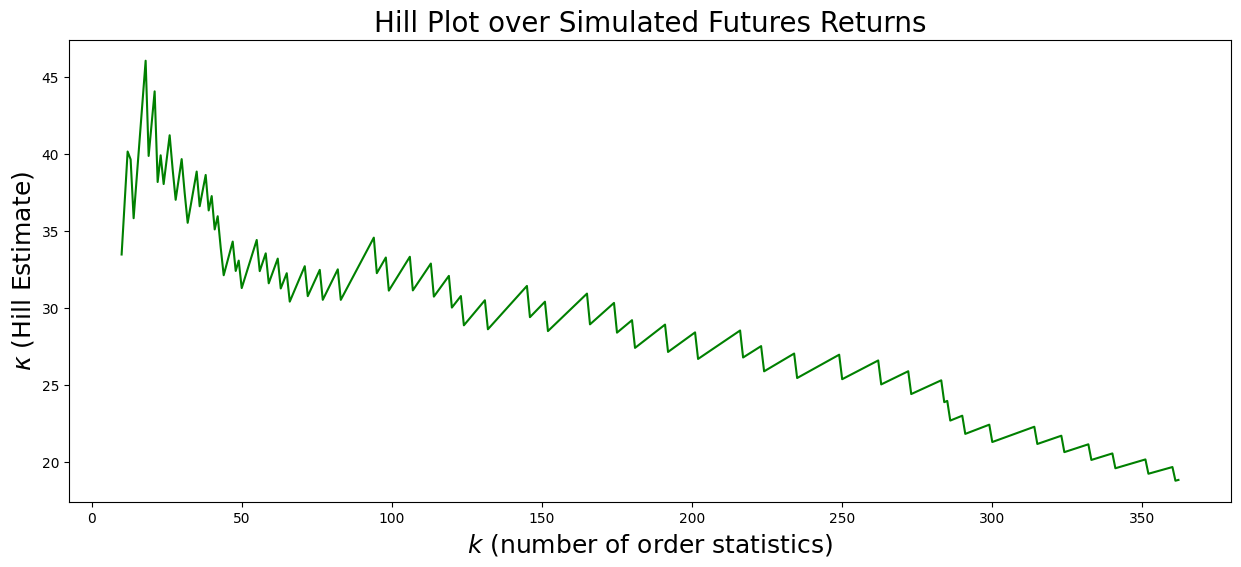

In [ ]:
import matplotlib.pyplot as plt
import powerlaw
import pandas as pd
import seaborn as sns

## PLOT SIMULATION ##

# Plot returns
plt.plot(output_returns, label='Returns')
plt.xlabel('Days')
plt.ylabel('Returns')
plt.title('End of Day Returns')
plt.legend()
plt.show()

# Histogram
sns.distplot(output_returns, hist=True, kde=False,
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

#Option 1
'''data=[]
for i in output_returns:
  data.append(abs(i))
print(data)'''

#Option 2
data=[]
for i in output_returns:
  if abs(i)<2:
    data.append(2)
  else:
    data.append(abs(i))
print(data)

#Option 3
'''data=[]
for i in output_returns:
  if i== 0:
    data.append(0.1)
  else:
    data.append(abs(i))
print(data)'''


# Plot returns on a log-log scale
plt.figure(figsize=(8, 6))
plt.hist(data, bins=50, density=True, alpha=0.7, color='blue', edgecolor = 'black')
plt.xscale('log')
plt.yscale('log')
plt.title('Simulation Power Law Distribution - Log-Log Plot')
plt.xlabel('Value (log scale)')
plt.ylabel('Frequency (log scale)')
plt.show()



### Hill Estimator FOR SIMULATION

# code found on GitHub under the profile AlinaSode

def Hill_estimator(data):
    """
    Returns the Hill Estimators for some 1D data set.
    """
    # sort data in such way that the smallest value is first and the largest value comes last:
    Y = np.sort(data)
    n = len(Y)

    Hill_est = np.zeros(n-1)

    for k in range(0, n-1):    # k = 0,...,n-2
        summ = 0

        for i in range(0,k+1):   # i = 0, ..., k
            summ += np.log(Y[n-1-i]) - np.log(Y[n-2-k])

        Hill_est[k] = (1 / (k+1)) * summ      # add 1 to k because of Python syntax

    kappa = 1. / Hill_est
    return kappa


n_obs = len(data)
k_max = int(round(0.1*n_obs))
k_min = 10

print("[INFO] computing Hill Estimators...")
#t0 = time()
print(min(data))
kap_gains_sim = Hill_estimator(data)

#print ("        done in %0.3f minutes" % ((time() - t0)/60))
print ("")

print ("Sample size n:", n_obs)
print ("Total number of exceeded k:", len(kap_gains_sim))


""" Hill Plot for Gains for k in range (10,...,round(0.1*n_obs)) """

plt.figure(figsize=(15, 6))
plt.plot(np.arange(k_min,k_max), kap_gains_sim[k_min-1:k_max-1], 'green')
plt.xlabel("$k$ (number of order statistics)", fontsize=18)
plt.ylabel("$\kappa$ (Hill Estimate)", fontsize=18)
plt.title("Hill Plot over Simulated Futures Returns", fontsize=20)
plt.show()

            Date  Price   Open   High    Low     Vol. Change % Return
0     12/05/2023  2.748  2.702  2.785  2.678             2.00%   0.02
1     12/04/2023  2.694  2.728  2.752  2.649  161.79K   -4.26%  -0.04
2     12/01/2023  2.814  2.809  2.844  2.754  133.19K    0.43%   0.00
3     11/30/2023  2.802  2.799  2.855  2.761  147.75K   -0.07%   0.00
4     11/29/2023  2.804  2.792   2.87   2.76  141.59K    3.62%   0.04
...          ...    ...    ...    ...    ...      ...      ...    ...
3623  01/08/2010  5.749  5.827  5.853  5.621  101.15K   -0.98%  -0.01
3624  01/07/2010  5.806  6.033  6.108  5.763  135.11K   -3.38%  -0.03
3625  01/06/2010  6.009   5.69  6.075   5.65  140.61K    6.60%   0.07
3626  01/05/2010  5.637  5.837  5.858  5.615   99.49K   -4.20%  -0.04
3627  01/04/2010  5.884  5.705  5.894  5.705   78.86K    5.60%   0.06

[3628 rows x 8 columns]
0       0.0200
1       0.0426
2       0.0043
3       0.0007
4       0.0362
         ...  
3623    0.0098
3624    0.0338
3625    0.0660


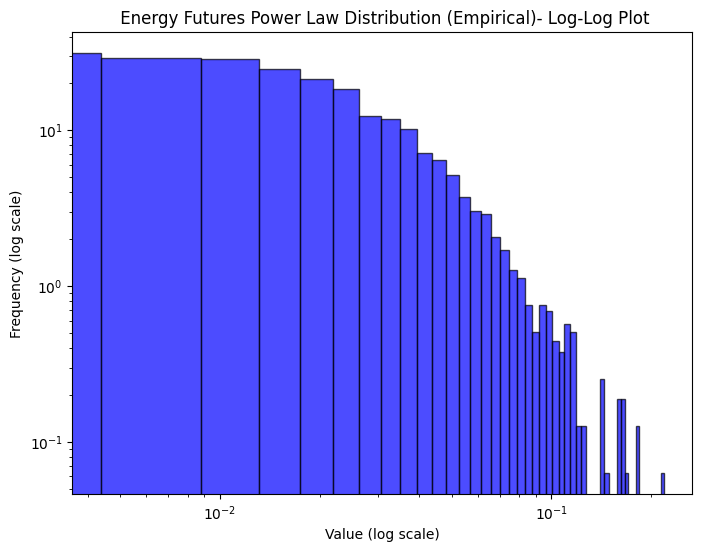

In [ ]:
## READ IN NATURAL GAS FUTURES DATA

## Load data from the drive

from google.colab import auth
auth.authenticate_user()

import gspread

# method 1
from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)

gsheets = gc.open_by_url('https://docs.google.com/spreadsheets/d/1VMZvoSCBruftaPjW7XwjlsjZBfLdOQ3BKNY2WiC46eE/edit?usp=drive_link')
sheets = gsheets.worksheet('Natural Gas Futures Historical Data').get_all_values()
futures_data = pd.DataFrame(sheets[1:], columns=sheets[0])

# method 2
'''
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)

#Path to the data will likely change for you
path = "/content/drive/MyDrive/ABMcore/Data/Gas_futures_data.gsheet"

futures_data=pd.read_csv(path)
'''

print(futures_data)

futures_data["Change"] = futures_data['Change %'].str.rstrip('%').astype('float') / 100.0
fdata = futures_data["Change"].abs()

print(fdata)

## PLOT NATURAL GAS FUTURES DATA
# Plot the data on a log-log scale
plt.figure(figsize=(8, 6))
plt.hist(fdata, bins=50, density=True, alpha=0.7, color='blue', edgecolor = 'black')
plt.xscale('log')
plt.yscale('log')
plt.title(' Energy Futures Power Law Distribution (Empirical)- Log-Log Plot')
plt.xlabel('Value (log scale)')
plt.ylabel('Frequency (log scale)')
plt.show()


[INFO] computing Hill Estimators...


<ipython-input-9-21cbfee64406>:76: RuntimeWarning: divide by zero encountered in log
  summ += np.log(Y[n-1-i]) - np.log(Y[n-2-k])
<ipython-input-9-21cbfee64406>:76: RuntimeWarning: invalid value encountered in double_scalars
  summ += np.log(Y[n-1-i]) - np.log(Y[n-2-k])



Sample size n: 3628
Total number of exceeded k: 3627


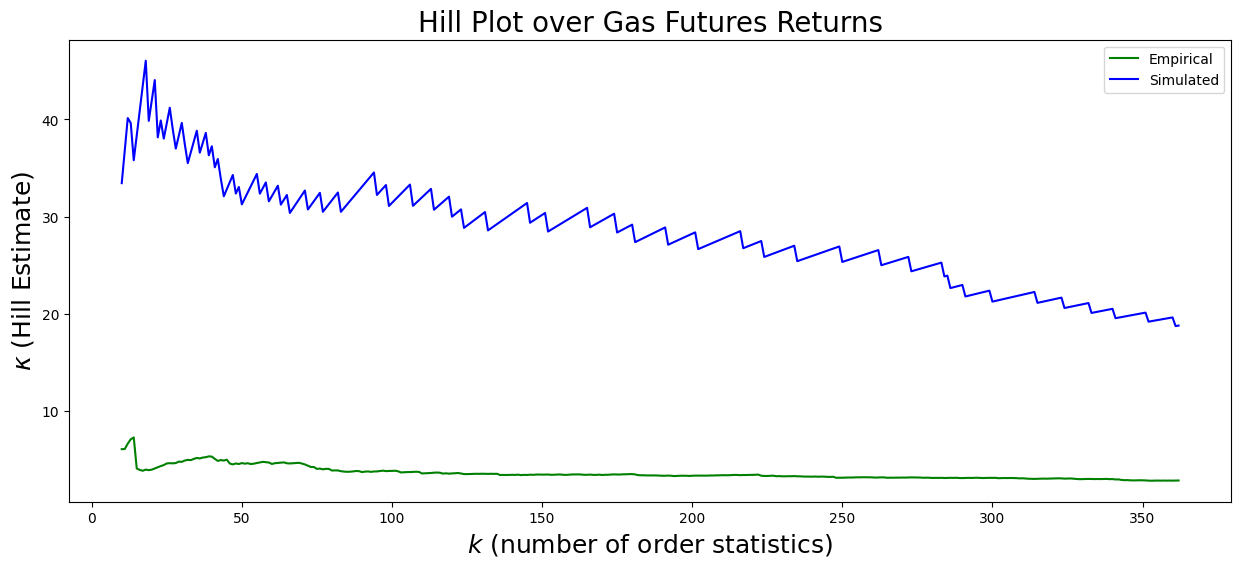

[53.38732798 28.65426366 33.61074582 40.83992098 41.76065971 34.81049225
 29.87506257 34.14292865 35.3869024  33.44768884 36.79245773 40.13722661
 39.62331361 35.80460767 38.36207964 40.91955162 43.4770236  46.03449557
 39.84982456 41.94718375 44.04454294 38.15711754 39.89153198 38.02456072
 39.60891742 41.19327412 38.97540461 37.00059437 38.32204417 39.64349397
 37.45028304 35.50652118 36.61609996 37.72567875 38.83525754 36.58176759
 37.5979278  38.61408801 36.31074536 37.24179012 35.07691386 35.93244834
 33.89797435 32.09993799 32.82948204 33.55902609 34.28857013 32.37824117
 33.05278786 31.26635163 31.89167866 32.5170057  33.14233273 33.76765976
 34.39298679 32.3669965  32.94497858 33.52296066 31.57625232 32.11144303
 32.64663375 33.18182447 31.24141528 31.73731076 32.23320624 30.38630562
 30.84670419 31.30710276 31.76750133 32.2278999  32.68829847 30.74239084
 31.16936849 31.59634614 32.02332379 32.45030144 30.50360786 30.89975861
 31.29590936 31.69206011 32.08821086 32.48436162 30

In [ ]:
## HILL ESTMATOR FOR GAS FUTURES ##

n_obs = len(fdata)
k_max = int(round(0.1*n_obs))
k_min = 10

print("[INFO] computing Hill Estimators...")
#t0 = time()

kap_gains = Hill_estimator(fdata)


print ("")

print ("Sample size n:", n_obs)
print ("Total number of exceeded k:", len(kap_gains))


""" Hill Plot for Gains for k in range (10,...,round(0.1*n_obs)) """

plt.figure(figsize=(15, 6))
plt.plot(np.arange(k_min,k_max), kap_gains[k_min-1:k_max-1], 'green', label = 'Empirical')
plt.plot(np.arange(k_min,k_max), kap_gains_sim[k_min-1:k_max-1], 'blue', label = 'Simulated')
plt.legend()
plt.xlabel("$k$ (number of order statistics)", fontsize=18)
plt.ylabel("$\kappa$ (Hill Estimate)", fontsize=18)
plt.title("Hill Plot over Gas Futures Returns", fontsize=20)
plt.show()
print(kap_gains_sim[0:100])
print(kap_gains[0:100])
print('kap_gains_sim', kap_gains_sim[72])
ratio = []
for i in range(100):
  ratio.append(kap_gains_sim[i]/kap_gains[i])
print(ratio)